In [1]:
from typing import List
import pandas as pd
import chess
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
moves = pd.read_parquet("../data/chess_game_0001.parquet")["Moves"][:100000]
moves = list(map(lambda x: x.tolist(), moves))

In [5]:
def get_moved_piece(moves: List[str]) -> List[str]:
    board = chess.Board()
    board.reset()
    moved_pieces = []
    for move in moves:
        move = chess.Move.from_uci(move)
        board.push(move)
        moved_piece = board.piece_at(move.to_square)
        moved_pieces.append(str(moved_piece))   
    return moved_pieces


pieces = []
for m in tqdm(moves):
    pieces.append(get_moved_piece(m))

100%|██████████| 100000/100000 [01:43<00:00, 968.19it/s]


In [6]:
games = []

for m, p in zip(moves, pieces):
    game = []
    for idx in range(len(m)):
        game.append(p[idx].lower() + m[idx])
    games.append(game)
games

[['pd2d4',
  'pf7f5',
  'pg2g3',
  'pg7g6',
  'bf1g2',
  'bf8g7',
  'ng1f3',
  'pd7d6',
  'pc2c3',
  'pe7e6',
  'pa2a4',
  'ng8f6',
  'qd1c2',
  'qd8e7',
  'nb1d2',
  'pe6e5',
  'pd4e5',
  'pd6e5',
  'pe2e4',
  'nb8c6',
  'ke1g1',
  'pf5e4',
  'nd2e4',
  'bc8f5',
  'nf3d2',
  'ke8c8',
  'pb2b4',
  'bg7h6',
  'rf1e1',
  'bh6d2',
  'bc1d2',
  'nf6e4',
  'bg2e4',
  'qe7e6',
  'bd2g5',
  'rd8d6',
  'ra1d1',
  'rd6d1',
  're1d1',
  'ph7h6',
  'bg5e3',
  'pa7a5',
  'qc2b1',
  'ph6h5',
  'pb4b5',
  'nc6e7',
  'be3g5',
  'rh8e8',
  'ph2h4',
  'qe6c4',
  'rd1e1',
  'bf5e4',
  're1e4',
  'qc4e6',
  'bg5f4',
  'qe6f5',
  'bf4e5',
  'ne7d5',
  'qb1e1',
  'nd5b6',
  'pf2f4',
  'nb6d7',
  'qe1e2',
  'pb7b6',
  're4e3',
  're8e7',
  're3e4',
  'nd7c5',
  're4d4',
  're7d7',
  'kg1g2',
  'kc8d8',
  'kg2h2',
  'kd8c8',
  'qe2g2',
  'kc8b8',
  'qg2a2',
  'kb8a7',
  'qa2g2',
  'ka7b8',
  'qg2e2',
  'kb8c8',
  'qe2f3',
  'kc8b8',
  'qf3d1',
  'kb8c8',
  'qd1e2',
  'kc8b8',
  'qe2d1',
  'kb8b7',
  'rd4d7',

In [27]:
from collections import defaultdict
import numpy as np
import pandas as pd

# Example input
offset = 1
co_occurrence = defaultdict(lambda: defaultdict(int))

move_occurrence = {} 
# Build co-occurrence matrix
for game in tqdm(moves):
    for idx, move in enumerate(game):
        neighbor_idx = idx + offset
        if neighbor_idx >= (len(game) - 1):
            break
        neighbor_move = game[neighbor_idx]
        co_occurrence[move][neighbor_move] += 1
        
        if move not in move_occurrence:
            move_occurrence[move] = [idx]
        else:
            move_occurrence[move].append(idx)

# Convert to DataFrame
unique_moves = list(sorted(set(m for game in moves for m in game)))
move_idx_map = {k: v for v, k in enumerate(unique_moves)}
matrix = np.zeros((len(unique_moves), len(unique_moves)))

for move, value in tqdm(co_occurrence.items()):
    move_idx = move_idx_map[move]
    for neighbor_move, count in value.items():
        neighbor_move_idx = move_idx_map[neighbor_move]
        matrix[move_idx, neighbor_move_idx] = count
count_df = pd.DataFrame(matrix, columns=unique_moves, index=unique_moves)

100%|██████████| 1959/1959 [00:00<00:00, 5080.25it/s]


In [30]:
mean_move_occurrence = {k: np.mean(v) for k, v in move_occurrence.items()} 
std_move_occurrence = {k: np.std(v) for k, v in move_occurrence.items()} 

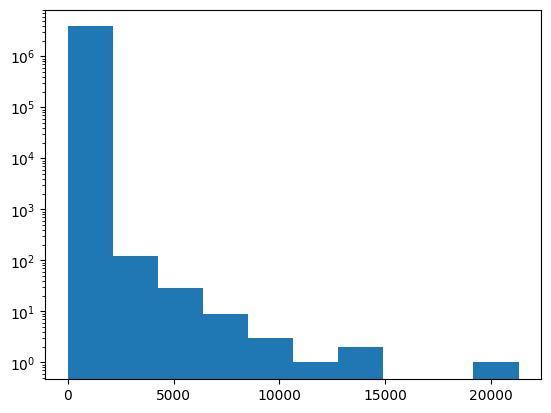

In [8]:
plt.hist(matrix.flatten())
plt.yscale("log")

(43, 51)


/tmp/ipykernel_6336/1193971748.py:12: RuntimeWarning: divide by zero encountered in log
  values = np.log(tmp_df.values)


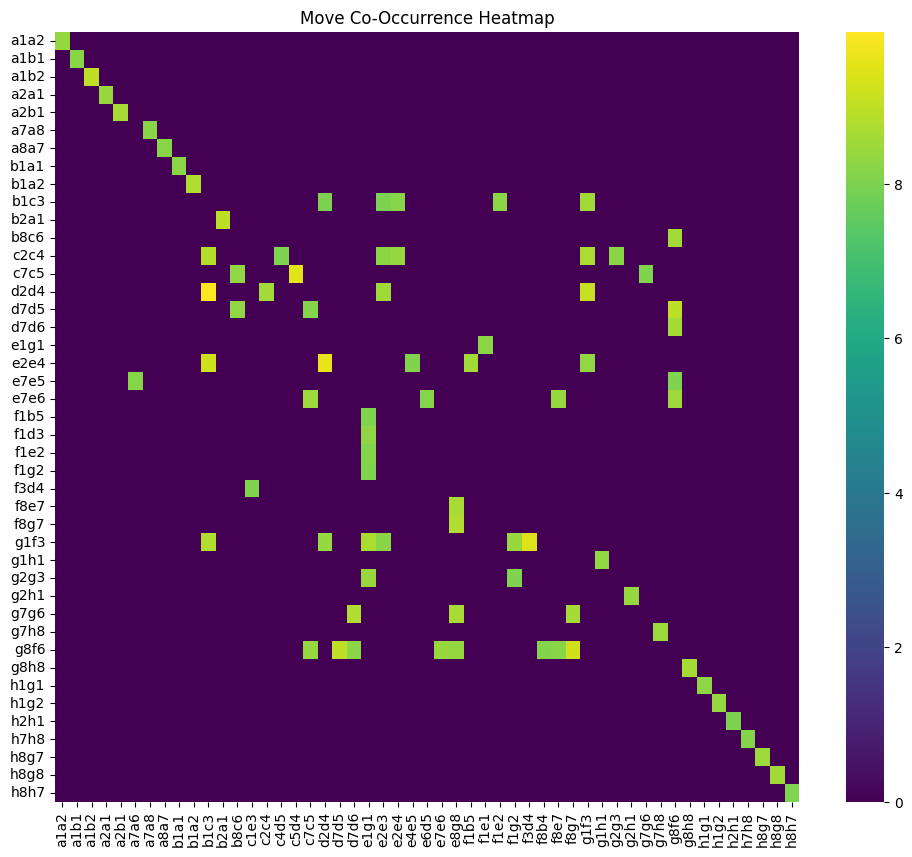

In [9]:


# prune rows and columns under a certain count
threshold = 3000
pruned_matrix = matrix.copy()
pruned_matrix[pruned_matrix <= threshold] = 0 

tmp_df = pd.DataFrame(pruned_matrix, columns=unique_moves, index=unique_moves)
tmp_df = tmp_df.drop(tmp_df[tmp_df.sum(axis=1) == 0].index)
drop_cols = tmp_df.columns[pruned_matrix.sum(axis=0) == 0]
tmp_df = tmp_df.drop(columns=drop_cols)
print(tmp_df.values.shape)

values = np.log(tmp_df.values)
values = np.where(values != -np.inf, values, 0)

tmp_df = pd.DataFrame(values, tmp_df.index, tmp_df.columns)
plt.figure(figsize=(12, 10))
sns.heatmap(tmp_df, cmap="viridis")
plt.title("Move Co-Occurrence Heatmap")
plt.show()

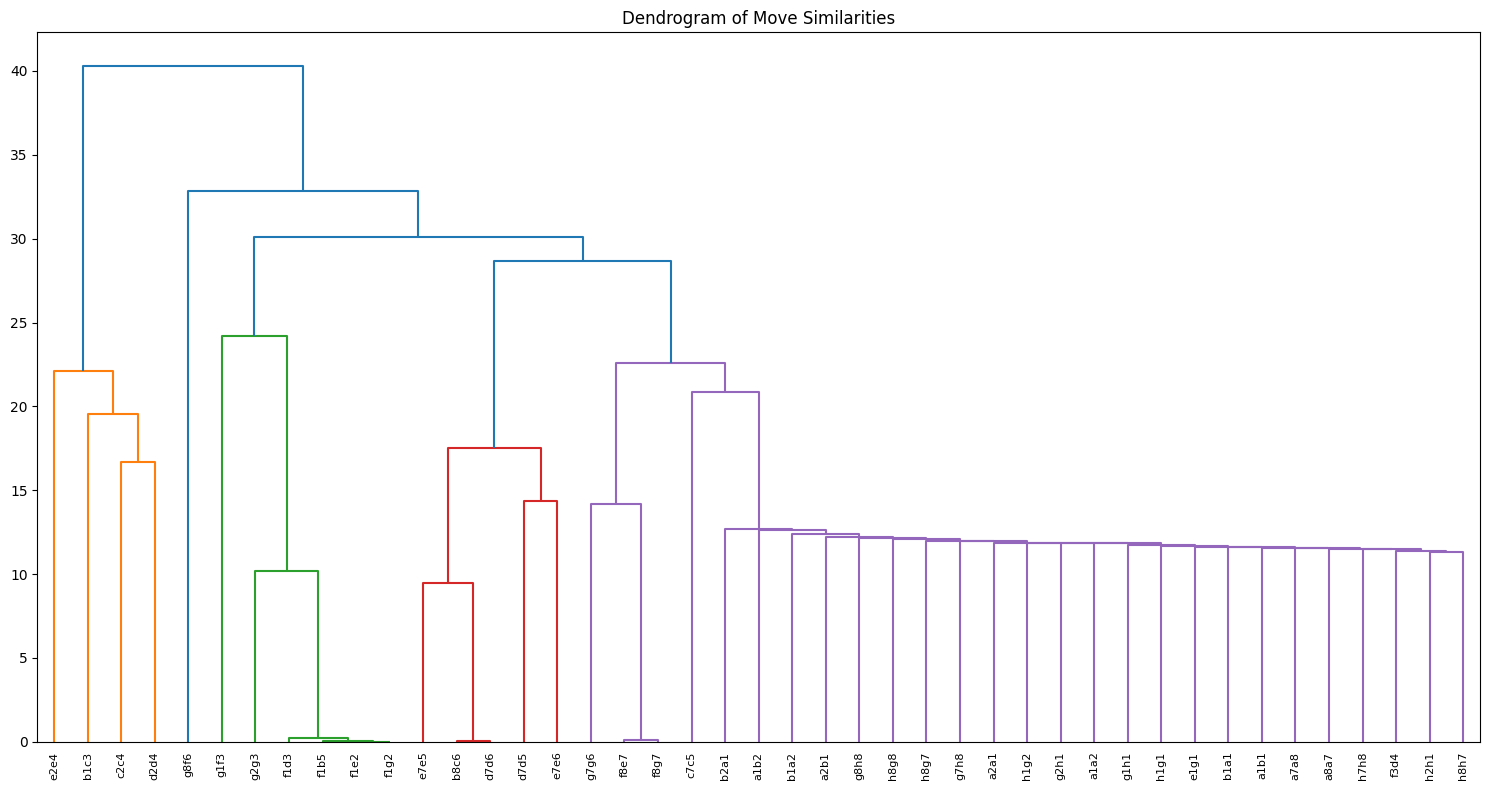

In [10]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Use linkage on the condensed distance matrix
linkage_matrix = linkage(tmp_df, method='ward')

plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, labels=tmp_df.index, leaf_rotation=90)
plt.title("Dendrogram of Move Similarities")
plt.tight_layout()
plt.show()

<Figure size 1500x800 with 0 Axes>

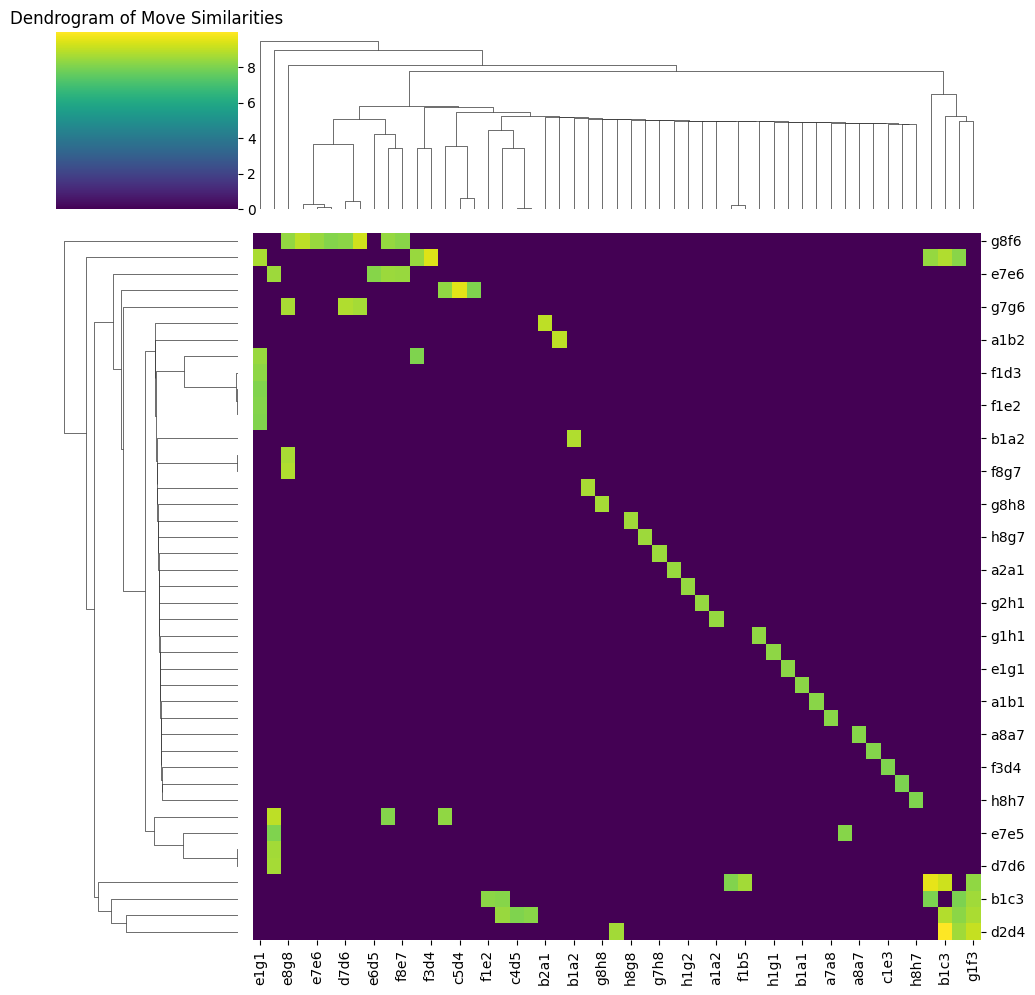

In [11]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Use linkage on the condensed distance matrix
linkage_matrix = linkage(tmp_df, method='ward')

plt.figure(figsize=(15, 8))
sns.clustermap(tmp_df, cmap="viridis")
plt.title("Dendrogram of Move Similarities")
plt.tight_layout()
plt.show()


/tmp/ipykernel_6336/1111271695.py:2: RuntimeWarning: divide by zero encountered in log2
  logits = np.log2(p_mat)


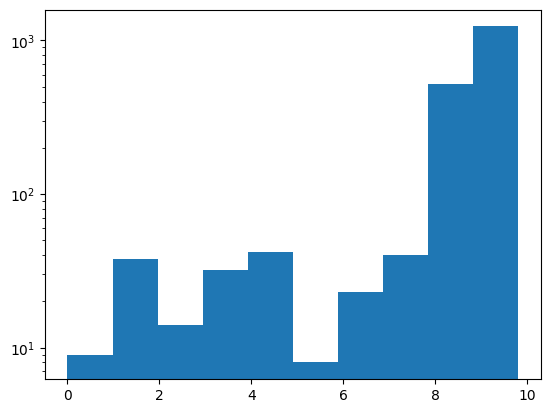

In [33]:
p_mat = matrix / matrix.sum(axis=1, keepdims=True)
logits = np.log2(p_mat)
logits[np.isinf(logits)] = 0
entropy = -np.sum(p_mat * logits, axis=1)
plt.hist(entropy)
plt.yscale("log")

<Axes: xlabel='mean_occurrence', ylabel='entropy'>

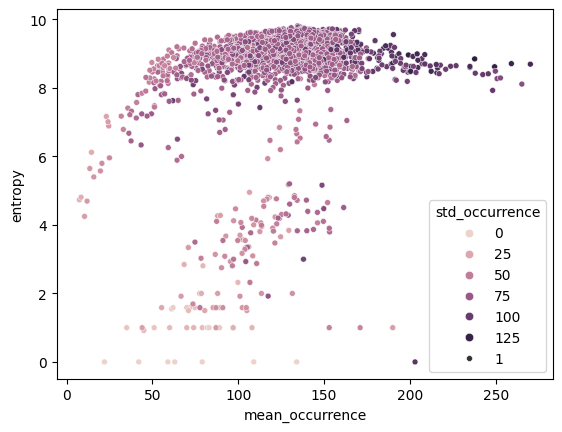

In [39]:
data = []
for idx, k in enumerate(unique_moves):
    data.append({"move": k, "entropy": entropy[idx], "mean_occurrence": mean_move_occurrence[k], "std_occurrence": std_move_occurrence[k]})
sns.scatterplot(pd.DataFrame(data), x="mean_occurrence", y="entropy", hue="std_occurrence", size=1)

In [19]:
keys = ("move", "piece", "number", "game_idx")
records = []
for game_id, game in enumerate(tqdm(moves)):
    for move_number, move in enumerate(game):
        records.append((game_id, move_number, move, pieces[game_id][move_number]))

# Create DataFrame
df = pd.DataFrame(records, columns=["game_id", "move_number", "move", "piece"])

100%|██████████| 100000/100000 [00:07<00:00, 12714.71it/s]


In [54]:
move_piece_count = df[["move", "piece"]].value_counts()
move_piece_count = move_piece_count.unstack(level=1)
move_piece_count = move_piece_count.replace(np.nan, 0)
move_piece_count.head()

piece    B       K    N    P      Q       R    b       k    n    p      q  \
move                                                                        
a1a2   0.0  4748.0  0.0  0.0  358.0  6657.0  0.0  2090.0  0.0  0.0  932.0   
a1a3   0.0     0.0  0.0  0.0  198.0  6508.0  0.0     0.0  0.0  0.0  285.0   
a1a4   0.0     0.0  0.0  0.0  169.0  5675.0  0.0     0.0  0.0  0.0  367.0   
a1a5   0.0     0.0  0.0  0.0  172.0  4669.0  0.0     0.0  0.0  0.0  423.0   
a1a6   0.0     0.0  0.0  0.0  153.0  4379.0  0.0     0.0  0.0  0.0  321.0   

piece        r  
move            
a1a2   11533.0  
a1a3    4387.0  
a1a4    3595.0  
a1a5    2995.0  
a1a6    2518.0

/tmp/ipykernel_41625/4039429664.py:4: RuntimeWarning: divide by zero encountered in log
  plt.matshow(np.log(count_mat))


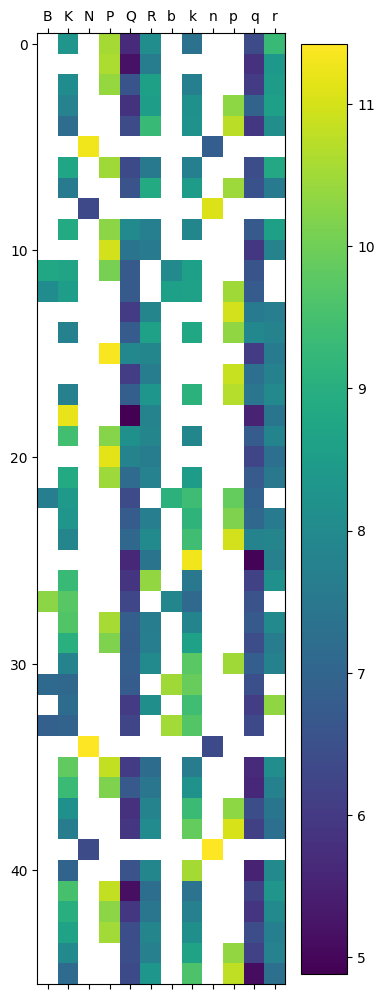

In [83]:
count_mat = move_piece_count.values
count_mat = count_mat[count_mat.sum(axis=1) >= 45000]

plt.matshow(np.log(count_mat))
plt.xticks(np.arange(len(move_piece_count.columns)), labels=move_piece_count.columns)
plt.colorbar()

/tmp/ipykernel_41625/1026624395.py:2: RuntimeWarning: divide by zero encountered in log2
  count_entropy = -np.sum(count_entropy * np.where(np.log2(count_entropy) == -np.inf, 0, np.log2(count_entropy)), axis=1)


((array([ 4.,  2.,  5.,  1.,  1.,  2., 10., 11.,  7.,  3.]),
  array([0.0549302 , 0.26826061, 0.48159102, 0.69492143, 0.90825185,
         1.12158226, 1.33491267, 1.54824308, 1.76157349, 1.9749039 ,
         2.18823431]),
  <BarContainer object of 10 artists>),
 2.4849066497880004)

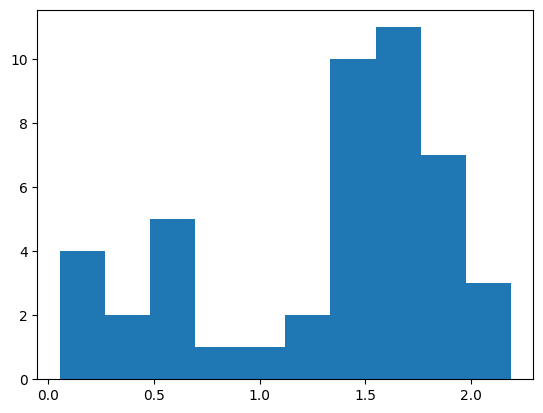

In [88]:
count_entropy = count_mat / count_mat.sum(axis=1, keepdims=True)
count_entropy = -np.sum(count_entropy * np.where(np.log2(count_entropy) == -np.inf, 0, np.log2(count_entropy)), axis=1)

plt.hist(count_entropy), np.log(12)